In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd #ised to get random sample of ndarray

We're not using keras for neural nets. After we dicided to use CIFAR-10, we saw that Eric had an import for it in the notebook "12. More Advanced CNN Techniques"

In [2]:
from keras.datasets import cifar10
import pickle

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_train_labels = [class_labels[int(val)] for val in y_train]
h = 32
w = 32
print(type(x_train))
print(x_train.shape)
print(y_train.shape)
print(class_labels)

Using TensorFlow backend.


<class 'numpy.ndarray'>
(50000, 32, 32, 3)
(50000, 1)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
vectorized_color = np.reshape(x_train,(len(x_train),32*32,3))
color_pixels = np.reshape(vectorized_color,(len(vectorized_color)*32*32,3))
print(color_pixels.shape)

(51200000, 3)


Only run this one once, as it takes a long time to convert all pixels to grayscale. Simply skip this cell and run the next one. You must make sure the data folder is present

In [4]:
#bw_pixels = [(0.21*pixel[0])+(0.72*pixel[1])+(0.07*pixel[2]) for pixel in color_pixels]#convert rgb to b/w
#vectorized_bw = np.reshape(bw_pixels,(len(x_train),32*32))#reconstruct to list in image vectors
#vectorized_bw.dump("data/vectorized_bw")

In [5]:
vectorized_bw_all = np.load("data/vectorized_bw")
print(vectorized_bw_all.shape)

#take a sample because kernel PCA takes too long to run on a laptop
# random_state = np.random.RandomState()
# vectorized_bw = pd.DataFrame(data=vectorized_bw).sample(5000, random_state=random_state).as_matrix()
# vectorized_bw_labels = pd.DataFrame(data=y_train_labels).sample(5000, random_state=random_state).as_matrix()
# print(vectorized_bw.shape)

df_bw = pd.DataFrame(data=vectorized_bw_all)
df_bw = df_bw.assign(y=pd.Series(y_train_labels,name='y'))
df_bw_sample = df_bw.sample(5000)
vectorized_bw = df_bw_sample.drop('y', axis=1).as_matrix()
vectorized_bw_labels = df_bw_sample.y.as_matrix()
print(vectorized_bw.shape)
print(vectorized_bw_labels.shape)

(50000, 1024)
(5000, 1024)
(5000,)


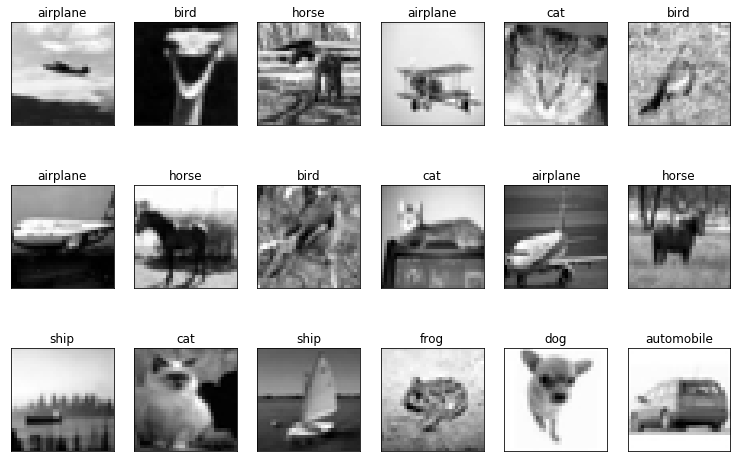

In [6]:
%matplotlib inline
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(vectorized_bw, vectorized_bw_labels, 32, 32) # defaults to showing a 3 by 6 subset of the faces

## Data Reduction

PCA

The first method of data reduction we are investigating is linear PCA. With any PCA, we are attempting to reduce the number of attributes needed to adequately explain variance in an image. We begin with 1024 attributes, each being a pixel from the image, and use linear PCA to find a linear eigenvector that combines n-number of weighted components, with the components having higher explained variance having a higher weight. We decided to reduce the number of components to 200 down from 1024, so our eigenvector will have 200 weighted components.

In [52]:
X = vectorized_bw
y = vectorized_bw_labels
n_components = 200
h = 32
w = 32
n_samples, n_features = X.shape

In [53]:
# lets do some PCA of the features and go from 1024 features to 200 features
from sklearn.decomposition import PCA
print ("Extracting the top %d eigenobjects from %d objects" % (
    n_components, X.shape[0]))
pca = PCA(n_components=n_components)
%time pca.fit(X)
eigenobjects = pca.components_.reshape((n_components, h, w))

Extracting the top 200 eigenobjects from 5000 objects
CPU times: user 1.35 s, sys: 141 ms, total: 1.49 s
Wall time: 957 ms


In [38]:
# manipulated from Sebastian Raschka Example (your book!)
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })


After running our data through scikit learn's PCA, we graphed the resulting 200 principal components with both their individual and cumulative explained variance. 

In [54]:
plot_explained_variance(pca)

In the above graph we see that the individual explained variance for each component is fairly low outside of the first 20 components, with 77.5% of the variance being explained with the first 20 principal components. With all 200 principal components, we acheive almost 96.5% explained variance. Considering this is less than 1/5 of the number of components we had initially, this is a very acceptable level of explained variance. With the CIFAR-10 dataset being so large, it is very imporant to reduce the dimensionality so that more images can be processed. Even if a 96.5% explained variance is not enough for some images, the performance benefits from reducing the dimensionality to such a degree means that more images can be processed which will make up for incorrectly categorizing certain images.

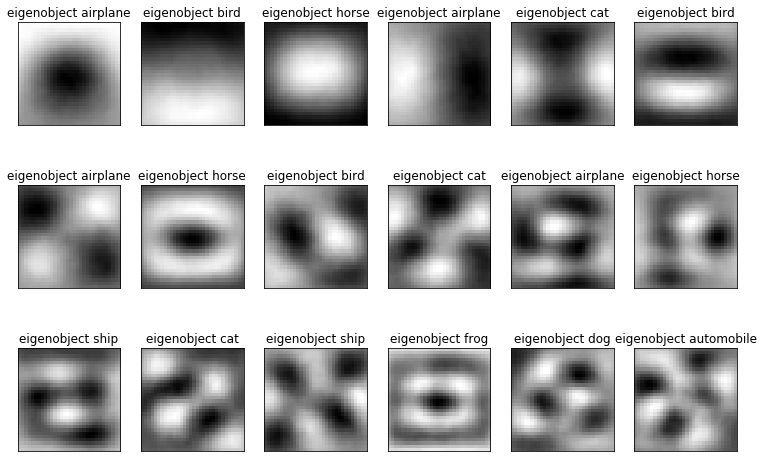

In [11]:
%matplotlib inline
eigenobject_titles = ["eigenobject {}".format(i) for i in y]
plot_gallery(eigenobjects, eigenobject_titles, h, w)

## Random PCA

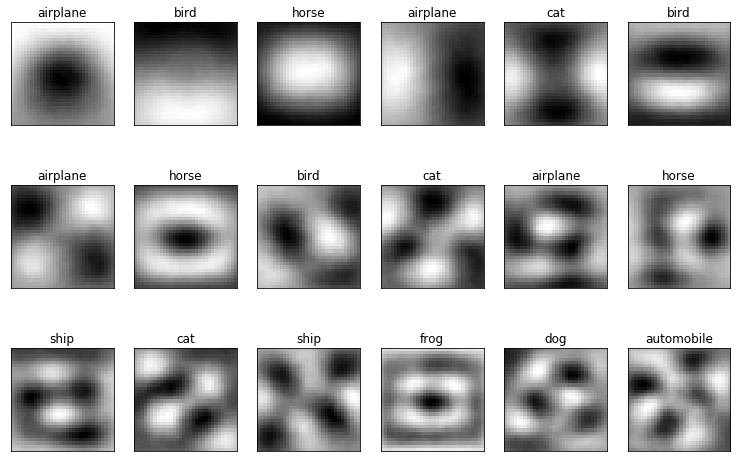

In [13]:
plot_gallery(eigenobjects, y, h, w)

## Non-linear PCA (Kernel PCA)

Next we wanted to examine Kernel PCA to see if a non-linear PCA approach would yield better results. To keep the comparison consistent, we used the same number of components for both linear and Kernel PCA. The difference with Kernel PCA from linear PCA is that while linear PCA attempts to create linear eigenvectors with n-number of components, Kernel PCA maps it to a higher dimensional space that better fits the curve, that then lets it find eigenvalues that map it to a lower dimension. 

In [14]:
from sklearn.decomposition import KernelPCA
print ("Extracting the top %d eigenobjects from %d objects" % (n_components, X.shape[0]))
kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter gamma=15
%time kpca.fit(X)

Extracting the top 200 eigenobjects from 5000 objects
CPU times: user 5min 52s, sys: 4.76 s, total: 5min 57s
Wall time: 3min 7s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=200, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

<function __main__.plt_reconstruct>

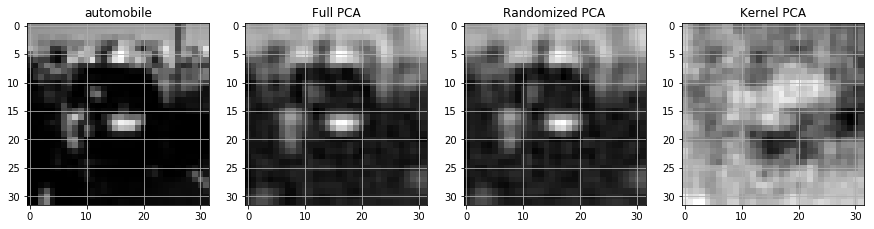

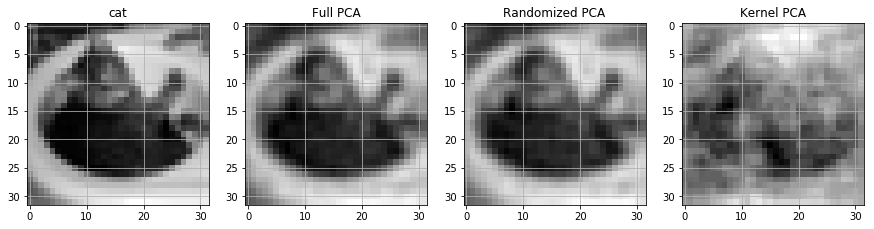

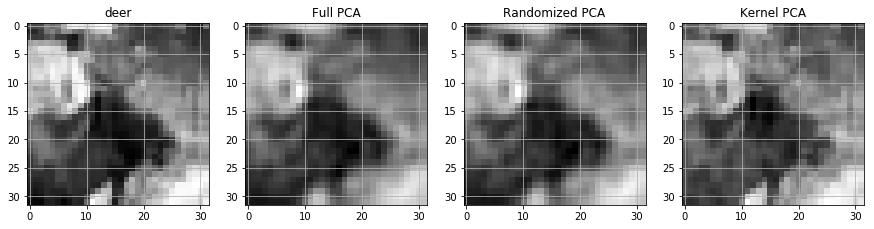

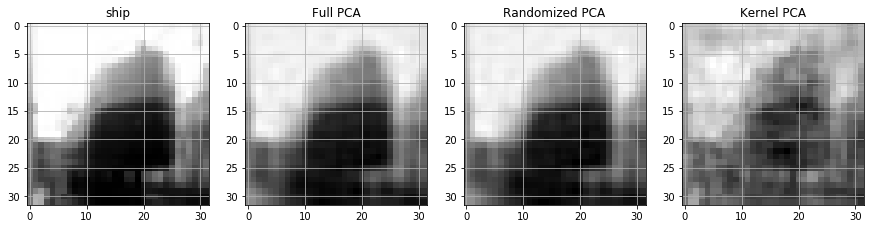

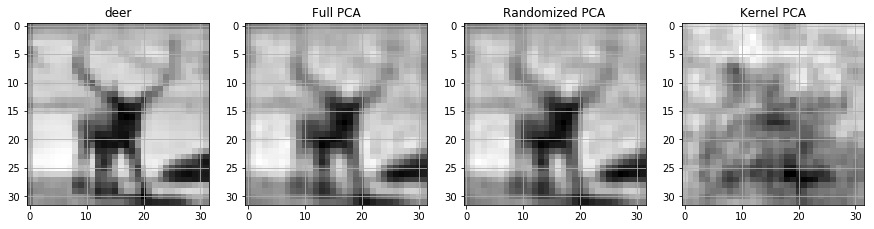

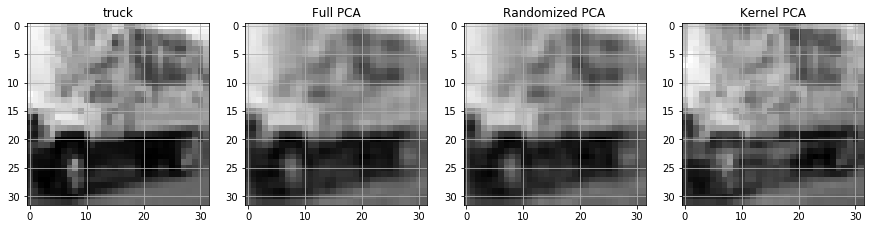

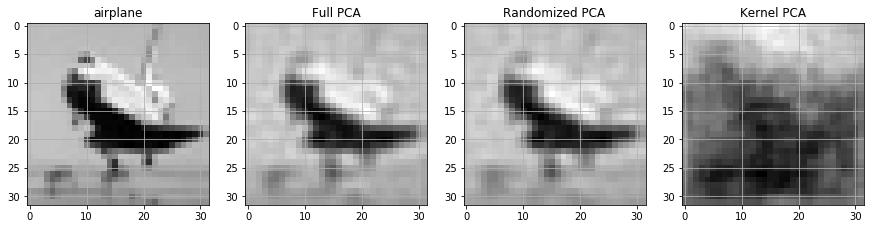

In [15]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods


def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(y[idx_to_reconstruct])
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    plt.grid()
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

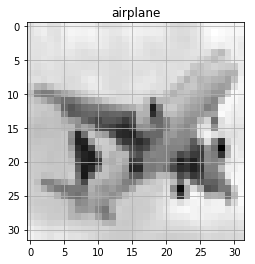

In [16]:
idx_to_reconstruct = int(np.random.rand(1)*len(X))
#show original image for comparison
plt.subplot()
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title(y[idx_to_reconstruct])
plt.grid()

/Users/oscar/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning:

Float image out of standard range; displaying image with stretched contrast.



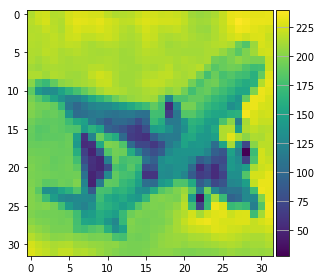

In [40]:
from skimage.io import imshow
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)
plt.grid()

/Users/oscar/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning:

Float image out of standard range; displaying image with stretched contrast.



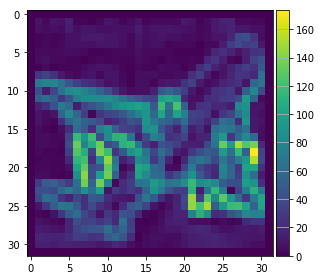

In [18]:
from skimage.filters import sobel_h, sobel_v
gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid()

## DAISY Feature Extraction

In [19]:
from skimage.feature import daisy

# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=4, radius=4, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

CPU times: user 2.44 ms, sys: 14 µs, total: 2.45 ms
Wall time: 2.46 ms


(3744,)

In [20]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 11.7 s, sys: 114 ms, total: 11.8 s
Wall time: 11.8 s
(5000, 3744)


In [21]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 2.73 s, sys: 88.5 ms, total: 2.82 s
Wall time: 1.52 s


In [22]:
from ipywidgets import fixed
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)), cmap=plt.cm.gray)
    plt.title("Original Image "+y[idx1])
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)), cmap=plt.cm.gray)
    plt.title("Closest Image  "+y[idx2])
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)), cmap=plt.cm.gray)
    plt.title("Next Closest Image "+y[idx3])
    plt.grid()
    
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

/Users/oscar/anaconda/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



<function __main__.closest_image>

In [23]:
#TODO: Analysis

## Gabor Filters
- Gabor filters might be better as regognising textures in nature vs machinery. It might categorize dogs with cats, but these will likely be different than truck and cars and airplanes whose textures are flatter.

In [24]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h,w))
gabr_feature

array([  1.74151091e+02,   1.25061222e+03,  -9.56647923e-01,
        -5.76292759e-02,   5.32389290e+01,   1.78667396e+02,
        -1.33777225e+00,   1.39038374e+00,   1.17476719e+02,
         3.42264925e+02,  -6.44041594e-01,  -8.83520419e-01,
         1.75231693e-01,   7.63202455e+00,  -7.57110051e-02,
         2.25629018e+00,   1.74152636e+02,   1.24854313e+03,
        -9.49933656e-01,  -7.89704546e-02,   5.33135160e+01,
         1.57415459e+02,  -1.10185341e+00,   4.60370477e-01,
         1.18494068e+02,   3.66230674e+02,  -5.99824603e-01,
        -9.27295340e-01,   2.82233249e-02,   3.28071091e+00,
        -4.71278568e-02,   1.11834454e+00,   1.74151091e+02,
         1.25056780e+03,  -9.50607872e-01,  -7.78812140e-02,
         5.32389290e+01,   1.63537135e+02,  -1.07144400e+00,
         2.73782152e-01,   1.17476719e+02,   4.07464068e+02,
        -6.24742923e-01,  -7.81310815e-01,   1.75231693e-01,
         3.10515798e+00,   4.45870855e-03,   9.72868550e-01,
         1.74152636e+02,

In [25]:
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h,w))
print(gabor_stats.shape)

CPU times: user 1min 46s, sys: 816 ms, total: 1min 47s
Wall time: 1min 50s
(5000, 64)


In [26]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(gabor_stats)

CPU times: user 513 ms, sys: 82.1 ms, total: 595 ms
Wall time: 419 ms


/Users/oscar/anaconda/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



<function __main__.closest_image>

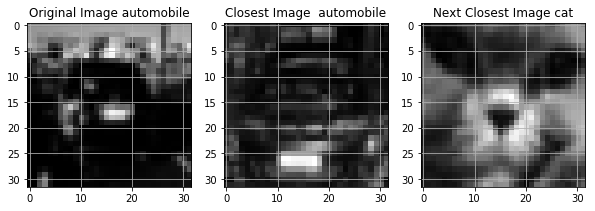

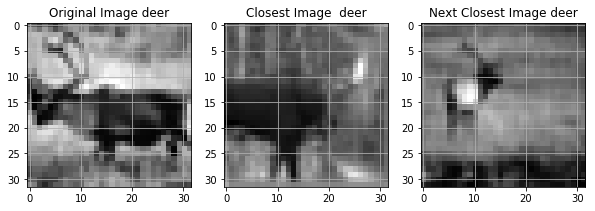

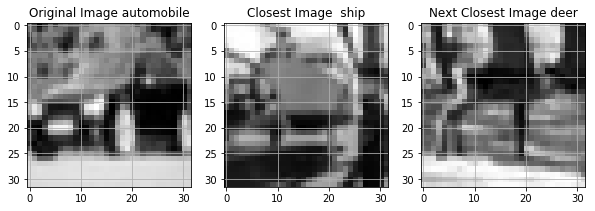

In [27]:
import copy
from ipywidgets import fixed
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    plt.imshow(X[idx1].reshape((h,w)), cmap=plt.cm.gray)
    plt.title("Original Image "+y[idx1])
    plt.grid()

    plt.subplot(1,3,2)
    plt.imshow(X[idx2].reshape((h,w)), cmap=plt.cm.gray)
    plt.title("Closest Image  "+y[idx2])
    plt.grid()
    
    plt.subplot(1,3,3)
    plt.imshow(X[idx3].reshape((h,w)), cmap=plt.cm.gray)
    plt.title("Next Closest Image "+y[idx3])
    plt.grid()

widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

In [28]:
#TODO: Analysis v

[20 points] Visualize the differences between statistics of extracted features in each target class. For example, a heat map of the pairwise differences (ordered by class) among all extracted features might be appropriate for your data. Based on your visualization, do you think the extracted features are sufficient for classification on your dataset? 